# Authorship Analysis

This Jupyter notebook uses statistical methods to analyze the authorship of a text. The text is split into words, and the frequency of each word is calculated. The frequency of each word is then compared to the frequency of the same word in a training set of texts of known authorship. The authorship of the text is then predicted based on the similarity of the word frequencies.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import nltk
from multiprocess import Pool

import os
import sys
from typing import List, Tuple, Dict, Callable, Union, Any, Optional, Self, Set
import csv

# Tokenization

The first step in the analysis is to tokenize the text. Tokenization is the process of splitting the text into words. The text is split into words using the `nltk` library.

# Frequency Analysis

The next step is to calculate the frequency of each word in the text. The frequency of each word is calculated by counting the number of times the word appears in the text and dividing by the total number of words in the text.

In [2]:
def tokenize(text: str) -> List[str]:
    '''
    Takes a string and returns a list of words.
    
    Parameters
    ----------
    text : str
        The text to be tokenized.
    
    Returns
    -------
    List[str]
        A list of words.
    '''
    # Split on whitespace and punctuation
    text = text.lower()
    
    # Split on punctuation
    for p in '!"#$%()*+,-./:;<=>?@[\\]^_`{|}~':
        text = text.replace(p, ' ' + p + ' ')
    
    return text.split()

def tokens_to_sentences(tokens: List[str]) -> List[str]:
    '''
    Takes a list of tokens and returns a list of sentences.
    
    Parameters
    ----------
    tokens : List[str]
        The tokens to be converted to sentences.
        
    Returns
    -------
    List[str]
        A list of sentences.
    '''
    sentences = []
    sentence = []
    for token in tokens:
        sentence.append(token)
        if token in '.!?':
            sentences.append(' '.join(sentence))
            sentence = []
    return sentences

def word_count(text: str) -> int:
    '''
    Takes a string and returns the number of words in it.
    
    Parameters
    ----------
    text : str
        The text to be tokenized.
        
    Returns
    -------
    int
        The number of words in the text.
    '''
    return len(tokenize(text))

def avg_word_length(text: str) -> float:
    '''
    Takes a string and returns the average length of the words in it.
    
    Parameters
    ----------
    text : str
        The text to be tokenized.
        
    Returns
    -------
    float
        The average length of the words in the text.
    '''
    words = tokenize(text)
    return sum(len(word) for word in words) / len(words)

def unique_words(text: str) -> int:
    '''
    Takes a string and returns the number of unique words in it.
    
    Parameters
    ----------
    text : str
        The text to be tokenized.
        
    Returns
    -------
    int
        The number of unique words in the text.
    '''
    return len(set(tokenize(text)))

def avg_sentence_length(text: str) -> float:
    '''
    Takes a string and returns the average length of the sentences in it.
    
    Parameters
    ----------
    text : str
        The text to be tokenized.
        
    Returns
    -------
    float
        The average length of the sentences in the text.
    '''
    sentences = tokens_to_sentences(tokenize(text))
    return sum(len(sentence) for sentence in sentences) / len(sentences)

def word_count_map(text: str) -> Dict[str, int]:
    '''
    Takes a string and returns a dictionary of words and their counts.
    
    Parameters
    ----------
    text : str
        The text to be tokenized.
        
    Returns
    -------
    Dict[str, int]
        A dictionary of words and their counts.
    '''
    return {word: text.count(word) for word in tokenize(text)}

def word_freq(text: str) -> Dict[str, float]:
    '''
    Takes a string and returns a dictionary of words and their frequencies.
    
    Parameters
    ----------
    text : str
        The text to be tokenized.
        
    Returns
    -------
    Dict[str, float]
        A dictionary of words and their frequencies.
    '''
    # wc = word_count(text)
    # return {word: count / wc for word, count in word_count_map(text).items()}
    
    # Do it in parallel with multiprocessing
    # Split up the text into chunks for each process
    # Send each chunk to a different process
    # Combine the results
    
    def partition_text(text: str, partitions: int=16) -> list[str]:
        length = len(text)
        chunk_size = length // partitions
        return [text[i:i+chunk_size] for i in range(0, length, chunk_size)]
        
    text_partitions = partition_text(text)
    with Pool(16) as pool:
        results = pool.map(word_count_map, text_partitions)
    
    # Combine the results
    combined = {}
    for result in results:
        for word, count in result.items():
            combined[word] = combined.get(word, 0) + count
    
    wc = sum(combined.values())
    return {word: count / wc for word, count in combined.items()}

def get_csv_chapters(path: str, start: int, end: int):
    with open(path, mode='r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        chapters = []
        text = ""
        for row in reader:
            chapters.append((row['Chapter'], row['Content']))

        num_chapters = len(chapters)
        # print(f'Total number of chapters: {num_chapters}')
        if num_chapters == 0:
            print("Error: No valid chapters found in the file. This may lead to a ZeroDivisionError.")

        if (start + end > num_chapters):
            print("This file only has {num_chapters} chapters. Using all of them.")
            for chapter_number, content in chapters:
                # print(f'Chapter {chapter_number}:{content}\n')
                text += content
        else:
            # Print the first 'start' chapters
            for chapter_number, content in chapters[:start]:
                # print(f'Chapter {chapter_number}:{content}\n')
                text += content
            # Print the last 'end' chapters
            for chapter_number, content in chapters[-end:]:
                # print(f'Chapter {chapter_number}:{content}\n')
                text += content
    
    return text




# Corpus

This implements an abstraction for managing a corpus of texts. The corpus is a collection of texts, each of which has an author and a title. The corpus can be used to train a model to predict the authorship of a text.

In [3]:
class Corpus:
    '''
    A class to represent a corpus of text data.
    
    This provides abstractions for managing text data, including:
    - reading data from files
    - managing multiple works with separate metadata
    '''
    
    def __init__(self, name: str):
        '''
        Initialize a new Corpus object.
        
        Parameters
        ----------
        name : str
            The name of the corpus. This is used to identify the corpus, maybe used in plots, etc.
            Should be a short, descriptive name, that distinguishes this corpus from others.
        '''
        self.works = []
        self.name = name
    
    def add_paths(self, paths: List[str], author: str, **metadata):
        '''
        Add multiple works to the corpus from files.
        
        Parameters
        ----------
        paths : List[str]
            A list of file paths to read texts from.
        author : str
            The author of the works.
        metadata : dict
            Additional metadata about the works.
        '''
        for path in paths:
            with open(path, 'r') as f:
                text = f.read()
            title = os.path.basename(path).replace('.txt', '').replace('_', ' ').title()
            self.add_work(title, author, text, **metadata)    
    
    def add_work(self, title: str, author: str, text: str, **metadata):
        '''
        Add a new work to the corpus.
        
        Parameters
        ----------
        title : str
            The title of the work.
        author : str
            The author of the work.
        text : str
            The text of the work.
        metadata : dict
            Additional metadata about the work, such as publication date, genre, etc.
        '''
        self.works.append({'title': title, 'author': author, 'text': text, **metadata})
    
    def from_paths(name: str, paths: List[str], author: str, **metadata) -> Self:
        '''
        Load multiple works from files.
        
        Parameters
        ----------
        paths : List[str]
            A list of file paths to read texts from.
        author : str
            The author of the works.
        metadata : dict
            Additional metadata about the works.
        '''
        works = Corpus(name)
        for path in paths:
            with open(path, 'r') as f:
                text = f.read()
            title = os.path.basename(path).replace('.txt', '').replace('_', ' ').title()
            works.add_work(title, author, text, **metadata)
        return works

    def from_paths_csv(name: str, paths: List[str], author: str, start_ch: int, end_ch: int, **metadata) -> Self:
        works = Corpus(name)
        for path in paths:
            # function that will get desired chapters of csv file
            text = get_csv_chapters(path, start_ch, end_ch)
            title = os.path.basename(path).replace('.csv', '').replace('_', ' ').title()
            works.add_work(title, author, text, **metadata)
        return works
    
    def add_paths_csv(self, paths: List[str], author: str, start_ch: int, end_ch: int, **metadata):
        for path in paths:
            text = get_csv_chapters(path, start_ch, end_ch)
            title = os.path.basename(path).replace('.txt', '').replace('_', ' ').title()
            self.add_work(title, author, text, **metadata)

    
    def collate_texts(self) -> str:
        '''
        Combine all texts in the corpus into a single string.
        
        Returns
        -------
        str
            A single string containing all the text in the corpus.
        '''
        return '\n\n'.join(work['text'] for work in self.works)
    
    def get_authors(self) -> List[str]:
        '''
        Get a list of authors in the corpus.
        
        Returns
        -------
        List[str]
            A list of the authors in the corpus.
        '''
        return list(set([work['author'] for work in self.works]))
    
    def get_titles(self) -> List[str]:
        '''
        Get a list of titles in the corpus.
        
        Returns
        -------
        List[str]
            A list of the titles in the corpus.
        '''
        return [work['title'] for work in self.works]
    
    def get_texts(self) -> List[str]:
        '''
        Get a list of texts in the corpus.
        
        Returns
        -------
        List[str]
            A list of the texts in the corpus.
        '''
        return [work['text'] for work in self.works]
    
    def get_works_by_author(self, author: str) -> List[Dict[str, str]]:
        '''
        Get a list of works by a specific author.
        
        Parameters
        ----------
        author : str
            The author to filter works by.
        
        Returns
        -------
        List[Dict[str, str]]
            A list of works by the specified author.
        '''
        return [work for work in self.works if work['author'] == author]
    
    def get_works_by_title(self, title: str) -> List[Dict[str, str]]:
        '''
        Get a list of works by a specific title.
        
        Parameters
        ----------
        title : str
            The title to filter works by.
        
        Returns
        -------
        List[Dict[str, str]]
            A list of works with the specified title.
        '''
        return [work for work in self.works if work['title'] == title]
    
    def get_works_by_metadata(self, **metadata) -> List[Dict[str, str]]:
        '''
        Get a list of works that match specific metadata criteria.
        
        Parameters
        ----------
        metadata : dict
            The metadata criteria to filter works by.
        
        Returns
        -------
        List[Dict[str, str]]
            A list of works that match the specified metadata criteria.
        '''
        return [work for work in self.works if all(work[key] == value for key, value in metadata.items())]
    
    def get_word_counts_per_work(self) -> Dict[str, Dict[str, int]]:
        '''
        Get a dictionary of word counts for the entire corpus.
        
        Returns
        -------
        Dict[str, Dict[str, int]]
            A dictionary of word counts for each work in the corpus.
            The keys are the titles of the works, and the values are dictionaries
            of words and their counts.
        '''
        return {work['title']: word_count_map(work['text']) for work in self.works}
    
    def get_word_counts_per_author(self) -> Dict[str, Dict[str, int]]:
        '''
        Get a dictionary of word counts for the entire corpus.
        
        Returns
        -------
        Dict[str, Dict[str, int]]
            A dictionary of word counts for each work in the corpus.
            The keys are the authors of the works, and the values are dictionaries
            of words and their counts.
        '''
        result = {}
        for author in self.get_authors():
            print(f'Starting {author}')
            result[author] = word_count_map(' '.join(work['text'] for work in self.get_works_by_author(author)))
            print(f'Finished {author}')
        return result
    
    def get_word_counts(self) -> Dict[str, int]:
        '''
        Get a dictionary of word counts for the entire corpus.
        
        Returns
        -------
        Dict[str, int]
            A dictionary of words and their counts in the entire corpus.
        '''
        return word_count_map(self.collate_texts())
    
    def get_word_freq_per_work(self) -> Dict[str, Dict[str, float]]:
        '''
        Get a dictionary of word frequencies for the entire corpus.
        
        Returns
        -------
        Dict[str, Dict[str, float]]
            A dictionary of word frequencies for each work in the corpus.
            The keys are the titles of the works, and the values are dictionaries
            of words and their frequencies.
        '''
        return {work['title']: word_freq(work['text']) for work in self.works}
    
    def get_word_freq_per_author(self) -> Dict[str, Dict[str, float]]:
        '''
        Get a dictionary of word frequencies for the entire corpus.
        
        Returns
        -------
        Dict[str, Dict[str, float]]
            A dictionary of word frequencies for each work in the corpus.
            The keys are the authors of the works, and the values are dictionaries
            of words and their frequencies.
        '''
        result = {}
        for author in self.get_authors():
            print(f'Starting {author}')
            result[author] = word_freq(' '.join(work['text'] for work in self.get_works_by_author(author)))
            print(f'Finished {author}')
        return result
    
    def get_word_freq(self) -> Dict[str, float]:
        '''
        Get a dictionary of word frequencies for the entire corpus.
        
        Returns
        -------
        Dict[str, float]
            A dictionary of words and their frequencies in the entire corpus.
        '''
        return word_freq(self.collate_texts())
    
    def __repr__(self):
        return f'Corpus({self.name!r})'
    
    def __str__(self):
        return f'Corpus: {self.name} ({len(self.works)} works)'
    
    def __len__(self):
        return len(self.works)
    
    def __getitem__(self, idx: int) -> Dict[str, str]:
        return self.works[idx]
    
    def __iter__(self):
        return iter(self.works)
    
    def __contains__(self, title: str) -> bool:
        return any(title == work['title'] for work in self.works)
    
    def __add__(self, other: Self) -> Self:
        new = Corpus(f'{self.name} + {other.name}')
        new.works = self.works + other.works
        return new
    
    def __iadd__(self, other: Self) -> Self:
        self.works.extend(other.works)
        return self
    
    def __eq__(self, other: Self) -> bool:
        return self.name == other.name and self.works == other.works
    
    def __ne__(self, other: Self) -> bool:
        return not (self == other)
    
    def __bool__(self) -> bool:
        return bool(self.works)
    
    def __dir__(self) -> List[str]:
        return list(self.__dict__.keys()) + [work for work in self.works[0]]

In [4]:
# # Load some texts into a corpus
# ac_paths = os.listdir('data/ac')
# ac_paths = [os.path.join('data/ac', path) for path in ac_paths]

# ml_paths = os.listdir('data/ml')
# ml_paths = [os.path.join('data/ml', path) for path in ml_paths]

# gc_paths = os.listdir('data/gc')
# gc_paths = [os.path.join('data/gc', path) for path in gc_paths]

# lc_paths = os.listdir('data/lc')
# lc_paths = [os.path.join('data/lc', path) for path in lc_paths]

# hm_paths = os.listdir('data/hm')
# hm_paths = [os.path.join('data/hm', path) for path in hm_paths]
# # paths = ac_paths + shake_paths

# # corpus = Corpus.from_paths('Shakespeare', ['data/shakespeare/hamlet.txt', 'data/shakespeare/othello.txt', 'data/shakespeare/macbeth.txt', 'data/shakespeare/coriolanus.txt'], 'William Shakespeare', genre='tragedy')

# TRAIN_SPLIT = 0.75

# corpus = Corpus.from_paths('Agatha Christie Dataset', ac_paths[:int(len(ac_paths) * TRAIN_SPLIT)], 'Agatha Christie', genre='mystery')
# corpus.add_paths(ml_paths, 'Maurice Leblanc', genre='mystery')
# corpus.add_paths(gc_paths, 'GK Chesterton', genre='mystery')
# corpus.add_paths(lc_paths, 'Lewis Carroll', genre='fantasy')
# corpus.add_paths(hm_paths, 'Herman Melville', genre='adventure')
# validation_corpus = Corpus.from_paths('Agatha Christie Dataset', ac_paths[int(len(ac_paths) * TRAIN_SPLIT):], 'Agatha Christie', genre='mystery')

# print(corpus)

In [5]:
ac_paths = os.listdir('data/ac_csv')
ac_paths = [os.path.join('data/ac_csv', path) for path in ac_paths]

gc_paths = os.listdir('data/gc_csv')
gc_paths = [os.path.join('data/gc_csv', path) for path in gc_paths]

TRAIN_SPLIT = 0.75

start_ch = 1
end_ch = 1

# Create training corpus from Agatha Christie dataset
corpus = Corpus.from_paths_csv('Agatha Christie Dataset', ac_paths[:int(len(ac_paths) * TRAIN_SPLIT)], 'Agatha Christie', start_ch, end_ch, genre='mystery')

# Add GK Chesterton dataset to the training corpus
corpus.add_paths_csv(gc_paths, 'GK Chesterton', start_ch, end_ch, genre='mystery')

# Create validation corpus from Agatha Christie dataset
validation_corpus = Corpus.from_paths_csv('Agatha Christie Dataset', ac_paths[int(len(ac_paths) * TRAIN_SPLIT):], 'Agatha Christie', start_ch, end_ch, genre='mystery')

# Print the corpus summary
print(corpus)

Corpus: Agatha Christie Dataset (20 works)


In [6]:
def get_most_used_words(corpus: Corpus, count: int = 500) -> Dict[str, float]:
    '''
    Look at all the works in the corpus, and return a dictionary of the most used words
    to their frequency in the corpus.
    
    Parameters
    ----------
    corpus : Corpus
        The corpus of works to analyze.
        
    Returns
    -------
    Dict[str, float]
        A dictionary of the most used words in the corpus to their frequency (0-1, over the entire corpus).
    '''
    # Get the word frequencies for the entire corpus
    word_freq = corpus.get_word_freq()
    
    # Get the top most common words
    return {word: freq for word, freq in sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:count]}

# Get the top most common words in each work
# top_word_freq = {work: {word: freq for word, freq in sorted(freqs.items(), key=lambda x: x[1], reverse=True)[:20]} for work, freqs in word_freq.items()}
# print(top_word_freq)

# top_words = get_most_used_words(corpus)
# print(top_words)
# word_freq_per_work = corpus.get_word_freq_per_work()
# # Get the word counts for each work in the corpus
# print(word_freq_per_work)

In [7]:
# Get the frequencies of the top words in each work
# For each of the words in the top words, get the frequency in each work
# top_words_list = list(top_words.keys())
# top_word_freq = {work['title']: {word: freq for word, freq in word_freq_per_work[work['title']].items() if word in top_words_list} for work in corpus}

# Use a different color for each author
# df = pd.DataFrame(top_word_freq).fillna(0)
# Get a list of authors
authors = corpus.get_authors()
# Create a color palette
palette = sns.color_palette('hsv', len(authors))
# Create a dictionary mapping authors to colors
colors = {author: palette[i] for i, author in enumerate(authors)}
# Create a list of colors for each work
work_colors = [colors[author] for author in corpus.get_authors()]
# Plot the heatmap with the colors
# sns.heatmap(df, cmap='Blues', cbar=False)
# plt.title('Word Counts per Work')
# plt.show()

In [8]:
# Get the frequencies of the top words in each work
# For each of the words in the top words, get the frequency in each work
# top_words_list = list(top_words.keys())
# word_freq_per_author = corpus.get_word_freq_per_author()
# top_word_freq = {work['author']: {word: freq for word, freq in word_freq_per_author[work['author']].items() if word in top_words_list} for work in corpus}

In [9]:
# Use a different color for each author
# df = pd.DataFrame(top_word_freq).fillna(0)

# sns.heatmap(df, cmap='Blues', cbar=False)
# plt.title('Word Frequencies per Author')
# plt.show()

In [10]:
# Cluster all the works by their frequencies of all the top words
# Use k-means clustering to group the works by their word frequencies

# Alternative clustering methods:
# - Hierarchical clustering
# - DBSCAN
# - Spectral clustering
# - Affinity propagation

# Use hierarchical clustering to group the works by their word frequencies
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

# avg_sentences_per_work = {work['title']: avg_sentence_length(work['text']) for work in corpus}
# avg_word_lengths_per_work = {work['title']: avg_word_length(work['text']) for work in corpus}

# def tokens_to_numbers(tokens: List[str], bank: Set[str] | None = None) -> List[int]:
#     # For every token, replace it with its index in the bank
#     if bank is None:
#         bank = set(tokens)
#     bank = {token: i for i, token in enumerate(bank)}
#     return [bank[token] for token in tokens if token in bank]

# all_tokens = tokenize(corpus.collate_texts())

# def get_words_in_percentile_range(work: Dict[str, Any], lower: float, upper: float) -> List[str]:
#     word_freqs = word_freq_per_work[work['title']]
#     # Sort them by frequency
#     sorted_words = sorted(word_freqs.items(), key=lambda x: x[1], reverse=True)
#     # Get the words in the percentile range
#     # Do this by slicing the sorted list
#     lower_idx = int(len(sorted_words) * lower)
#     upper_idx = int(len(sorted_words) * upper)
#     return [word for word, freq in sorted_words[lower_idx:upper_idx]]

def vocab_richness(work: Dict[str, Any]) -> float:
    # Get the number of unique words
    unique = unique_words(work['text'])
    # Get the total number of words
    total = word_count(work['text'])
    
    # Return the ratio of unique words to total words
    return unique / total

def punctuation_density(work: Dict[str, Any]) -> float:
    # Get the number of punctuation marks
    punctuation = sum(1 for char in work['text'] if char in '.,?!')
    # Get the total number of characters
    total = len(work['text'])
    
    # Return the ratio of punctuation marks to total characters
    return punctuation / total

def sentence_length_variation(work: Dict[str, Any]) -> float:
    # Get the sentences in the work
    sentences = tokens_to_sentences(tokenize(work['text']))
    # Get the lengths of the sentences
    lengths = [len(sentence) for sentence in sentences]
    
    # Get the standard deviation of the sentence lengths
    return np.std(lengths)

def word_length_variation(work: Dict[str, Any]) -> float:
    # Get the words in the work
    words = tokenize(work['text'])
    # Get the lengths of the words
    lengths = [len(word) for word in words]
    
    # Get the standard deviation of the word lengths
    return np.std(lengths)

def adverb_density(work: Dict[str, Any]) -> float:
    # Get the adverbs in the work
    adverbs = [word for word in tokenize(work['text']) if word.endswith('ly')]
    # Get the total number of words
    total = word_count(work['text'])
    
    # Return the ratio of adverbs to total words
    return len(adverbs) / total

def quote_density(work: Dict[str, Any]) -> float:
    # Get the quotes in the work
    quotes = sum(1 for char in work['text'] if char == '"')
    # Get the total number of characters
    total = len(work['text'])
    
    # Return the ratio of quotes to total characters
    return quotes / total

def avg_word_length(work: Dict[str, Any]) -> float:
    # Get the words in the work
    words = tokenize(work['text'])
    # Get the total number of characters
    total = sum(len(word) for word in words)
    # Get the total number of words
    count = len(words)
    
    # Return the average word length
    return total / count

def passive_voice_density(work: Dict[str, Any]) -> float:
    # Get the sentences in the work
    sentences = tokens_to_sentences(tokenize(work['text']))
    # Get the number of passive voice sentences
    passive = sum(1 for sentence in sentences if 'was' in sentence and 'by' in sentence)
    # Get the total number of sentences
    total = len(sentences)
    
    # Return the ratio of passive voice sentences to total sentences
    return passive / total

def avg_sentence_length(work: Dict[str, Any]) -> float:
    # Get the sentences in the work
    sentences = tokens_to_sentences(tokenize(work['text']))
    # Get the total number of characters
    total = sum(len(sentence) for sentence in sentences)
    # Get the total number of sentences
    count = len(sentences)
    # Return the average sentence length
    return total / count

def pronoun_density(work: Dict[str, Any]) -> float:
    # Get the pronouns in the work
    pronouns = [word for word in tokenize(work['text']) if word in ['he', 'she', 'it', 'they', 'them', 'her', 'his', 'hers', 'its', 'their', 'theirs']]
    # Get the total number of words
    total = word_count(work['text'])
    
    # Return the ratio of pronouns to total words
    return len(pronouns) / total

def contraction_density(work: Dict[str, Any]) -> float:
    # Get the contractions in the work
    contractions = [word for word in tokenize(work['text']) if "'" in word]
    # Get the total number of words
    total = word_count(work['text'])
    
    # Return the ratio of contractions to total words
    return len(contractions) / total

def ngram_density(work: Dict[str, Any], n: int) -> float:
    # Get the n-grams in the work
    tokens = tokenize(work['text'])
    ngrams = [tuple(tokens[i:i+n]) for i in range(len(tokens) - n + 1)]
    
    # Get the total number of n-grams
    total = len(ngrams)
    # Get the number of unique n-grams
    unique = len(set(ngrams))
    
    # Return the ratio of unique n-grams to total n-grams
    return unique / total

def capitalize_density(work: Dict[str, Any]) -> float:
    # Count capital letters
    capitalized = sum(1 for char in work['text'] if char.isupper())
    total = len(work['text'])
    return capitalized / total

def avg_syllable_count(work: Dict[str, Any]) -> float:
    # Count the number of syllables in the word
    # This is a very simple heuristic
    # It doesn't work well for all words
    def syllable_count(word: str) -> int:
        return sum(1 for char in word if char in 'aeiou')
    
    # Get the words in the work
    words = tokenize(work['text'])
    # Get the total number of syllables
    total = sum(syllable_count(word) for word in words)
    # Get the total number of words
    count = len(words)
    
    # Return the average number of syllables per word
    return total / count

# Get the expected grade level of the work
def grade_level(work: Dict[str, Any]) -> float:
    # Get the average number of words per sentence
    avg_words_per_sentence = word_count(work['text']) / len(tokens_to_sentences(tokenize(work['text'])))
    # Get the average number of syllables per word
    avg_syllables_per_word = avg_syllable_count(work)
    
    # Use the Flesch-Kincaid Grade Level formula
    return 0.39 * avg_words_per_sentence + 11.8 * avg_syllables_per_word - 15.59

def featurize_with_names(work: Dict[str, Any]) -> Dict[str, float]:
    return {
        'Vocabulary Richness': vocab_richness(work),
        'Punctuation Density': punctuation_density(work),
        'Word Length Variation': word_length_variation(work),
        'Sentence Length Variation': sentence_length_variation(work),
        'Adverb Density': adverb_density(work),
        'Quote Density': quote_density(work),
        'Average Word Length': avg_word_length(work),
        'Average Sentence Length': avg_sentence_length(work),
        'Passive Voice Density': passive_voice_density(work),
        'Pronoun Density': pronoun_density(work),
        'Contraction Density': contraction_density(work),
        'Average Syllable Count': avg_syllable_count(work),
        'Capitalize Density': capitalize_density(work),
        'Bigram Density': ngram_density(work, 2),
        'Trigram Density': ngram_density(work, 3),
        'Quadgram Density': ngram_density(work, 4),
        'Quintgram Density': ngram_density(work, 5),
        'Grade Level': grade_level(work)
    }

def featurize(work: Dict[str, Any]) -> List[float]:
    print(f'Featurizing {work["title"]}')
    # Get the features for the work
    features = featurize_with_names(work)
    # Get the values of the features, sorted by name
    return [features[name] for name in sorted(features.keys())]

# Get the frequencies of all the top words in each work
X = np.array([featurize(work) for work in corpus])

# Scale the data
X_scaled = X

Featurizing Pg65238
Featurizing Pg863
Featurizing Pg1155
Featurizing Pg69087
Featurizing Pg66446
Featurizing Pg67173
Featurizing Pg67160
Featurizing Pg70114
Featurizing Pg61262
Featurizing Pg20897.Csv
Featurizing Pg63084.Csv
Featurizing Pg13342.Csv
Featurizing Pg19094.Csv
Featurizing Pg1718.Csv
Featurizing Pg470.Csv
Featurizing Pg16769.Csv
Featurizing Pg5265.Csv
Featurizing Pg11505.Csv
Featurizing Pg25308.Csv
Featurizing Pg1696.Csv


Before Resampling:
Training set class distribution: Counter({np.int64(0): 9, np.int64(1): 7})
Test set class distribution: Counter({np.int64(0): 2, np.int64(1): 2})

After Resampling:
Resampled training set class distribution: Counter({np.int64(0): 9, np.int64(1): 9})
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.67      1.00      0.80         2

    accuracy                           0.75         4
   macro avg       0.83      0.75      0.73         4
weighted avg       0.83      0.75      0.73         4



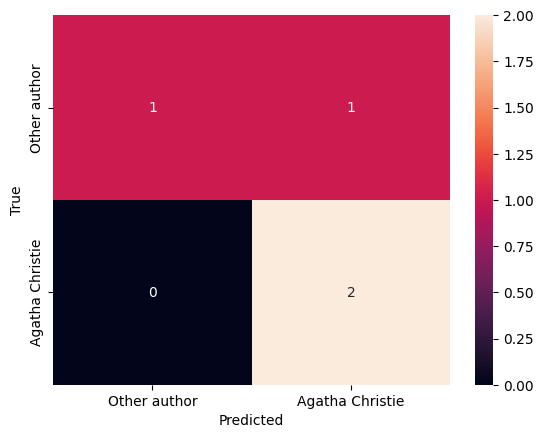

In [11]:
#supervised binary classification with balanced smaples
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.metrics import accuracy_score

# Prepare the labels
authors = corpus.get_authors()
author_to_label = {author: 1 if author == 'Agatha Christie' else 0 for author in authors}
y = np.array([author_to_label[work['author']] for work in corpus])

# Feature Extraction using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
X = vectorizer.fit_transform([work['text'] for work in corpus]).toarray()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Print class distribution before resampling
print("Before Resampling:")
print("Training set class distribution:", Counter(y_train))
print("Test set class distribution:", Counter(y_test))

# Address class imbalance by oversampling the minority class
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Print class distribution after resampling
print("\nAfter Resampling:")
print("Resampled training set class distribution:", Counter(y_train_resampled))

# Train the classifier
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred = classifier.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', xticklabels=['Other author', 'Agatha Christie'], yticklabels=['Other author', 'Agatha Christie'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Accuracy: 93.75%

Classification Report:
                 precision    recall  f1-score   support

Agatha Christie       0.88      1.00      0.93         7
  GK Chesterton       1.00      0.89      0.94         9
        Unknown       0.00      0.00      0.00         0

       accuracy                           0.94        16
      macro avg       0.62      0.63      0.62        16
   weighted avg       0.95      0.94      0.94        16



/root/python_environments/p3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


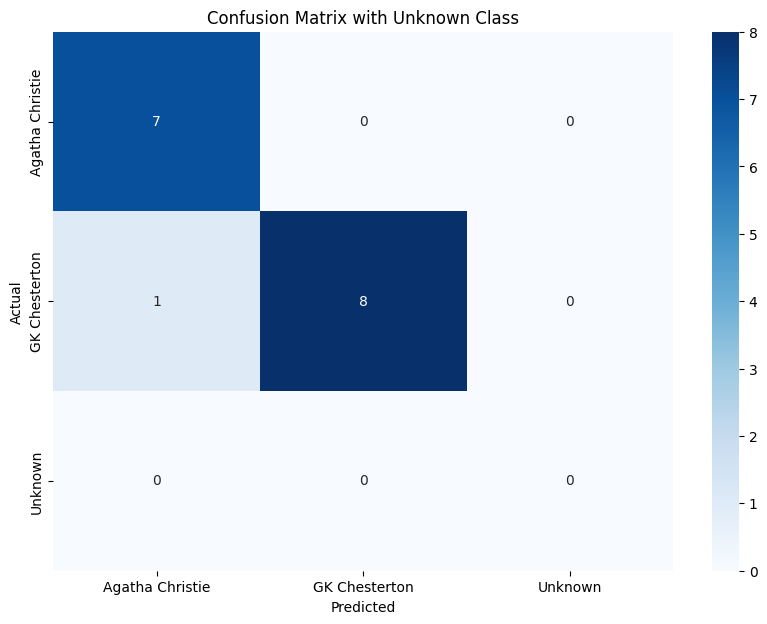

In [12]:
# Prepare the labels
authors = corpus.get_authors()
author_to_label = {author: idx for idx, author in enumerate(authors)}
label_to_author = {idx: author for author, idx in author_to_label.items()}
y = np.array([author_to_label[work['author']] for work in corpus])

# Feature Extraction using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
X = vectorizer.fit_transform([work['text'] for work in corpus])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.8, stratify=y, random_state=42
)

# Handle class imbalance using RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Initialize and train the logistic regression model
model = LogisticRegression(
    multi_class='multinomial', solver='lbfgs', class_weight='balanced'
)
model.fit(X_train_resampled, y_train_resampled)

# Get predicted probabilities for the test set
probs = model.predict_proba(X_test)

# Set a threshold for the minimum acceptable probability
threshold = 0.2  # Adjusted threshold

# Get the class labels (integer labels)
class_labels = model.classes_

# Map integer labels to author names
label_to_author = {idx: author for author, idx in author_to_label.items()}

# Predict classes with the "unknown" option
predicted_classes = []
for prob in probs:
    max_prob = np.max(prob)
    if max_prob < threshold:
        predicted_classes.append('Unknown')
    else:
        predicted_label = class_labels[np.argmax(prob)]
        predicted_author = label_to_author[predicted_label]
        predicted_classes.append(predicted_author)

# Convert y_test to author names
y_test_authors = [label_to_author[label] for label in y_test]

# Evaluate the performance
labels = authors + ['Unknown']  # Include 'Unknown' in the list of labels

# Compute confusion matrix
cm = confusion_matrix(y_test_authors, predicted_classes, labels=labels)

# Calculate accuracy
accuracy = accuracy_score(y_test_authors, predicted_classes)

print(f'Accuracy: {accuracy * 100:.2f}%')

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_authors, predicted_classes, labels=labels, zero_division=0))

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Unknown Class')
plt.show()

Accuracy: 95.00%


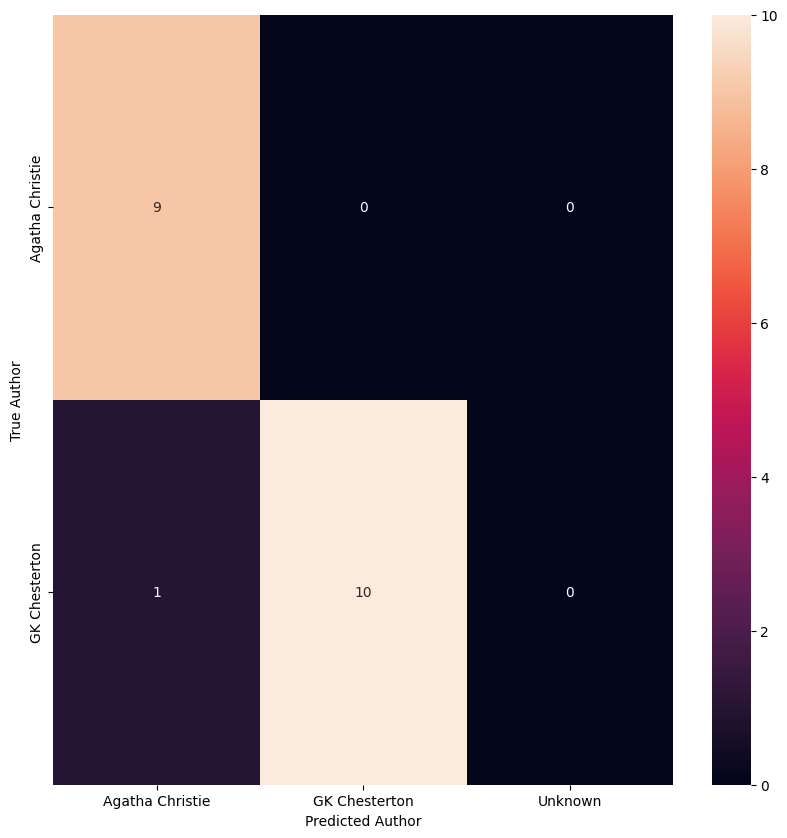

In [13]:
clustering_algorithm = KMeans(n_clusters=len(corpus.get_authors()))

most_common_clusters = {}
cluster_to_author = {}
while len(set(most_common_clusters.values())) < len(corpus.get_authors()):
    # Fit the model
    clustering_algorithm.fit(X_scaled)

    # Get the cluster assignments
    clusters = clustering_algorithm.predict(X_scaled)

    # Print the cluster assignments and true authors
    predicted_assignments = {work['title']: cluster for work, cluster in zip(corpus, clusters)}

    # Now assign the numbers to the authors
    author_assignments = {author: [] for author in corpus.get_authors()}
    for work in corpus:
        author_assignments[work['author']].append(predicted_assignments[work['title']])
        
    # Get the most common cluster for each author
    # Start with the most common cluster
    most_common_clusters = {}
    # Get number of works by each author
    author_counts = {author: len(works) for author, works in author_assignments.items()}
    authors_sorted_by_count = sorted(author_counts, key=lambda x: author_counts[x], reverse=True)
    
    # most_common_clusters = {author: max(set(assignments), key=assignments.count) for author, assignments in author_assignments.items()}
    most_common_clusters = {}
    for author, assignments in author_assignments.items():
        # Get the most common cluster for this author
        most_common_cluster = max(set(assignments), key=assignments.count)
        # If this cluster is already taken, find the next most common cluster
        while most_common_cluster in most_common_clusters.values():
            assignments.remove(most_common_cluster)
            if len(assignments) == 0:
                break
            most_common_cluster = max(set(assignments), key=assignments.count)
        most_common_clusters[author] = most_common_cluster
        
    cluster_to_author = {cluster: author for author, cluster in most_common_clusters.items()}

# Get the percent accuracy
correct = 0
confusion_matrix_unsupervised = np.zeros((len(corpus.get_authors()), len(corpus.get_authors()) + 1))
for work in corpus:
    true_author = work['author']
    try:
        predicted_author = cluster_to_author[predicted_assignments[work['title']]]
        if true_author == predicted_author:
            correct += 1
        confusion_matrix_unsupervised[authors.index(true_author), authors.index(predicted_author)] += 1
    except Exception as e:
        confusion_matrix_unsupervised[authors.index(true_author), -1] += 1
    
# SHow the confusion matrix
print(f'Accuracy: {correct / len(clusters) * 100:.2f}%')

# for work, cluster in zip(corpus, clusters):
#     print(f'{work["title"]} (by {work["author"]}): {cluster}')

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix_unsupervised, annot=True, fmt='g', xticklabels=list(most_common_clusters.keys()) + ['Unknown'], yticklabels=most_common_clusters.keys())
plt.xlabel('Predicted Author')
plt.ylabel('True Author')
plt.show()


In [14]:

def predict_author(work: Dict[str, Any]) -> str:
    # Get the features for the work
    features = featurize(work)
    # Predict the cluster
    cluster = clustering_algorithm.predict([features])[0]
    # Find the author with that cluster
    author = None
    for a, c in most_common_clusters.items():
        if c == cluster:
            author = a
            break
    return author

# Predict the authors of the validation works
for work in validation_corpus:
    print(f'{work["title"]} (by {work["author"]}): {predict_author(work)}')

Featurizing Pg61168
Pg61168 (by Agatha Christie): Agatha Christie
Featurizing Pg72824


Pg72824 (by Agatha Christie): Agatha Christie
Featurizing Pg58866
Pg58866 (by Agatha Christie): Agatha Christie


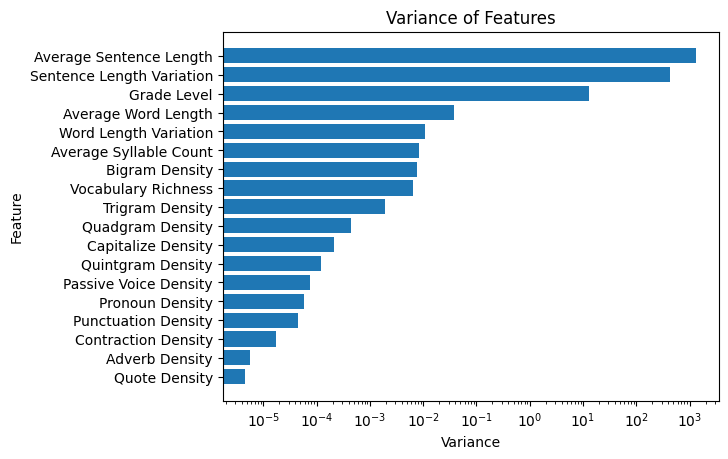

In [15]:
# Identify the variance in the features
# Get the variance of each feature
variances = np.var(X_scaled, axis=0)
# Get the indices of the features sorted by variance
sorted_indices = np.argsort(variances)

feature_names = sorted(featurize_with_names(corpus[0]).keys())

# Plot the variances of the features
plt.barh(range(len(variances)), variances[sorted_indices])
plt.yticks(range(len(variances)), [feature_names[i] for i in sorted_indices])
plt.xlabel('Variance')
plt.ylabel('Feature')
plt.title('Variance of Features')
# Log scale
plt.xscale('log')
plt.show()

In [16]:
# Plot the clusters as a 3d graph over the three most varying features
from mpl_toolkits.mplot3d import Axes3D

# Get the three most varying features
most_varying = sorted_indices[-3:]

df = pd.DataFrame()
for work in corpus:
    features = featurize_with_names(work)
    df = pd.concat([df, pd.DataFrame([work | features])])

# Get the features for the three most varying features
X_3d = df[feature_names].values
# Scale the data
X_3d_scaled = X_3d


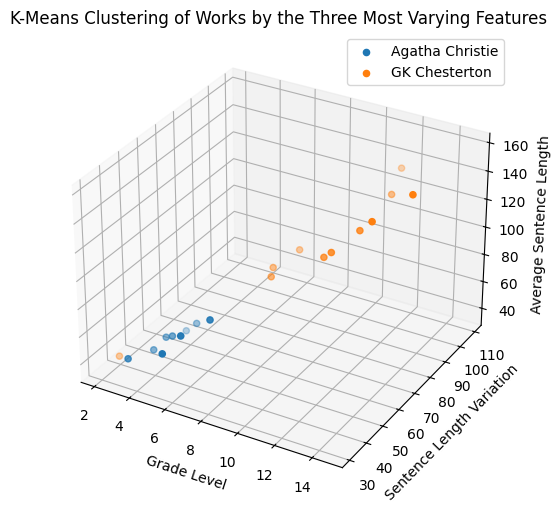

In [17]:
# Plot the clusters
fig = plt.figure(figsize=(6, 10))
ax = fig.add_subplot(111, projection='3d')

# Show the clusters by the three most varying features, colored by author
for author in corpus.get_authors():
    author_data = df[df['author'] == author]
    ax.scatter(author_data[feature_names[most_varying[0]]], author_data[feature_names[most_varying[1]]], author_data[feature_names[most_varying[2]]], label=author)
    
ax.set_xlabel(feature_names[most_varying[0]])
ax.set_ylabel(feature_names[most_varying[1]])
ax.set_zlabel(feature_names[most_varying[2]])
plt.title('K-Means Clustering of Works by the Three Most Varying Features')
plt.legend()
plt.show()

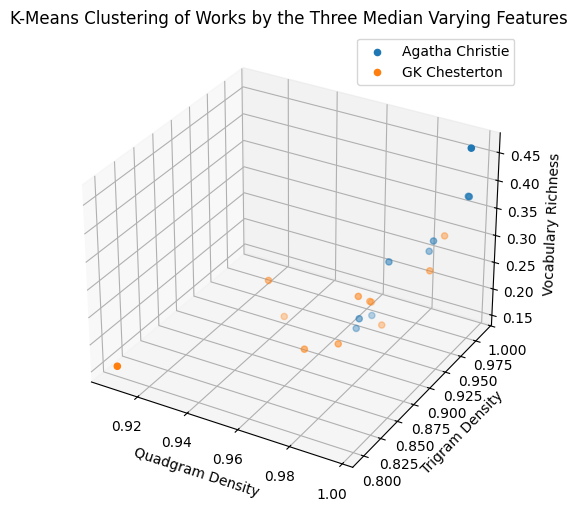

In [18]:

# Plot the clusters
fig = plt.figure(figsize=(6, 10))
ax = fig.add_subplot(111, projection='3d')

# Show the clusters by the three median varying features, colored by author
median_varying = sorted_indices[len(sorted_indices) // 2 - 1:len(sorted_indices) // 2 + 2]
for author in corpus.get_authors():
    author_data = df[df['author'] == author]
    ax.scatter(author_data[feature_names[median_varying[0]]], author_data[feature_names[median_varying[1]]], author_data[feature_names[median_varying[2]]], label=author)
    
ax.set_xlabel(feature_names[median_varying[0]])
ax.set_ylabel(feature_names[median_varying[1]])
ax.set_zlabel(feature_names[median_varying[2]])

plt.title('K-Means Clustering of Works by the Three Median Varying Features')
plt.legend()
plt.show()


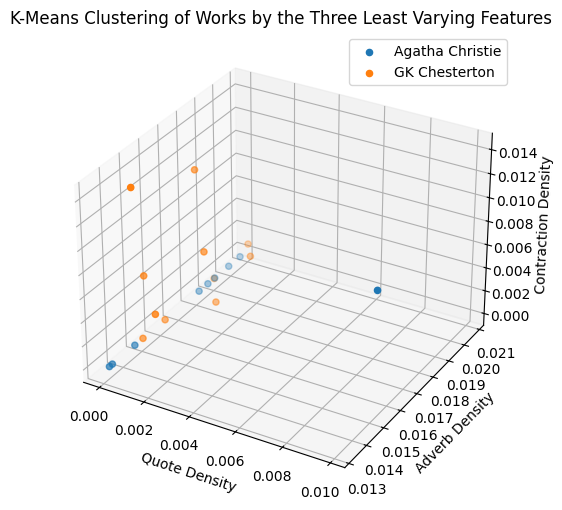

In [19]:

# Plot the clusters
fig = plt.figure(figsize=(6, 10))
ax = fig.add_subplot(111, projection='3d')

# Show the clusters by the three least varying features, colored by author
for author in corpus.get_authors():
    author_data = df[df['author'] == author]
    ax.scatter(author_data[feature_names[sorted_indices[0]]], author_data[feature_names[sorted_indices[1]]], author_data[feature_names[sorted_indices[2]]], label=author)
    
ax.set_xlabel(feature_names[sorted_indices[0]])
ax.set_ylabel(feature_names[sorted_indices[1]])
ax.set_zlabel(feature_names[sorted_indices[2]])
plt.title('K-Means Clustering of Works by the Three Least Varying Features')
plt.legend()
plt.show()
